# King County advanced EDA

This notebook follows some advanced exploratory data analaysis ideas outlined in Michael P. Notters ["Advanced exploratory data analysis (EDA)"](https://miykael.github.io/blog/2022/advanced_eda/) and is used as an practice approach to improve my EDA.

It uses some tools to get a quick handle on tabular data, but is in no way a complete approach.

In this notebook we first look int the structure of our data, followed by the quality and content.

1. **Structure**: general exploration of shape, data types, etc.
2. **Quality**: informaton about missing data, duplicate entries, outliers (unwanted entries)
3. **Content**: more in-depth analysis to understand our feature values and how they relate to each other


Beforehand however we need to load the data. For this purpose we are using pandas.

In [113]:
import pandas as pd

# load the data into a pandas data frame using the pd.read_csv method
df = pd.read_csv('data/King_County_House_prices_dataset.csv')

### 1. Structure Analysis

As mentioned, before we are looking into the quality and Content of our data, we start out with a very basic analysis of the structure.
The first step is to find out how many observations and features we have.

In [114]:
# display size of the dataframe
df.shape

(21597, 21)

With this we know that our dataset contains roughl 21k observations and 21 column features and we shortly have a look at the column names to get a first glance at the features.

In [115]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Next, we want to understand with how many different data types we are dealing.

In [116]:
# display how often the different data types are represented within our dataset
df.dtypes.value_counts()

int64      11
float64     8
object      2
dtype: int64

#### 1.1 Structure of non-numerical features

We are dealing with numerical data (int and float) as well as with 2 non-numerical features. We start by looking into the 2 non-numerical columns in our dataset.

In [117]:
# display the first 5 entries of our non-numerical features
df.select_dtypes(exclude='number').head()

,date,sqft_basement
0,10/13/2014,0.0
1,12/9/2014,400.0
2,2/25/2015,0.0
3,12/9/2014,910.0
4,2/18/2015,0.0


Even though sqft_basement is a numerical feature it was stored as a non-numerical one. Quite similar with date, which is ideally stored as a dateformat for further analysis.
Thus, in the next step we look more in detail into this two features and try to convert them to their ideal data type. The direct convertion using .astype is not working as currently there are some values existing, which cannot be converted automatically.

Thhus, in order to check if the sqft_basement contains only numerical data and can be converted, we are extracting the individual values of the sqft_basement series and parsing it into a list.

In [118]:
# create a lit of unique values available in the sqft_basement series
value_list = set(df['sqft_basement'].values)

# check for values not containing numbers and the decimal seperator
for element in value_list:
    if re.search('[^0123456789.]', element):
        print(element)

?


Some observations contain a question mark instead of a number. As we cannot convert the ? into a float or int, we investigate first how many observations hold this value. Based on this, we can either drop all impacted observations or impede the data with a different value.

In [119]:
len(df[df['sqft_basement'] == '?'])

454

With 454 entries the amount is to high as to drop the observations. Accordingly, we impede the missing data. We could either choose the median or mean to fill in. However, in this case, we treat the missing value as not having a basement size and fill it with 0 instead.

In [120]:
# replace the question mark with 0.0
df['sqft_basement'] = df['sqft_basement'].replace('?', 0.0)

# double check the amount of observations containing a question mark
len(df[df['sqft_basement'] == '?'])

0

From looking at the column names earlier on, we saw that we have multiple columns describing the sqft size of property/ground. Thus, we shortly check if we are dealing with int or float values for the other types and try to convert the sqft_basement in accordance.

In [121]:
# check the data type of the sqft features
df[['sqft_living', 'sqft_lot', 'sqft_above']].dtypes

sqft_living    int64
sqft_lot       int64
sqft_above     int64
dtype: object

In [122]:
# check the first entries of the sqft_basement again
df['sqft_basement'].head()

0      0.0
1    400.0
2      0.0
3    910.0
4      0.0
Name: sqft_basement, dtype: object

As we can see we are dealing with float like values which are currently cast as a string. These values cannot automatically cast into int values due due the decimal values.


In [127]:
# convert the object type values into float and afterwards to int
df['sqft_basement'] = df['sqft_basement'].astype('float').astype('int')
df['sqft_basement'].dtypes

dtype('int64')

As a last action for the object type data feature, we are now casting the date column into a date type, so that we can use it later on for further visualisations and data analysis.

In [130]:
# convert the date column into a date type object
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# double check the data types of our data frame
df.dtypes.value_counts()

int64             12
float64            8
datetime64[ns]     1
dtype: int64

With this we would actually move to look a bit further into the descriptive statistics of the non numerical values. However, as we have casted them now to different data types (int and date time respectively), we move now to the date feature and afterwards the numerical data types.

#### 1.2 Structure of date time feature

For this feature we are only shortly checking the range to understand with which time period our data set is dealing.

In [147]:
start = df.date.min()
end = df.date.max()

print(f'start date: {start.date()}')
print(f'end date: {end.date()}')

start date: 2014-05-02
end date: 2015-05-27


#### 1.3 Structure of numerical features

Next, we take a closer look at the numerical columns. We investigate how many unique values the individual features have. This gives us some insights about the number of binary (2), ordinal (3 to 10) and continuous (more than 10) features in the dataset.

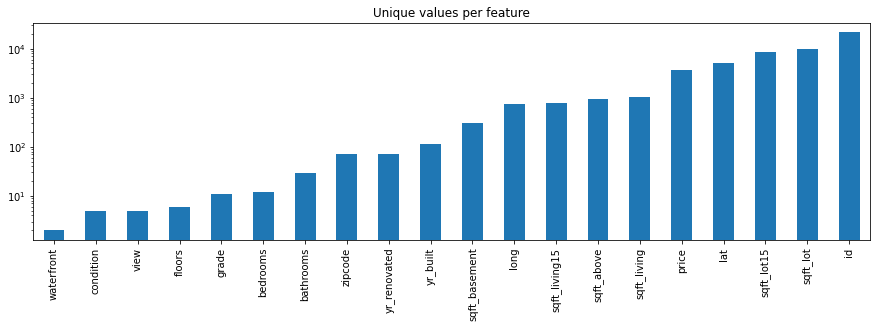

In [133]:
# get the amount of unique values per numerical feature and sort them in ascending order
unique_values = df.select_dtypes(include="number").nunique().sort_values()

# plot the unique values to visualise the amount of unique values
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

Before we conclude this section, we are using the .describe method to look into the basic descriptive statistics and get some insights about min, max, median, mean, percentiles, standard deviation and count.

In [138]:
df.select_dtypes(include="number").describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### 1.4 Conclusion of structural investigation

With this basic structural investigation we have a slightly better understanding of our data frame and already "corrected" some of the data types. We got a rough estimation about the values (unique features) our data frame represents as well as with how many observations and which time frame we are dealing.

df.describe(), df.info() are helpful methods to get a insight directly in the beginning, but looking at the different data types seperately helps to understand to deal with the data set later on.

### 2. Quality Investigation